In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.cm as cm
import seaborn as sns
import json
import joblib
from sklearn.decomposition import TruncatedSVD, LatentDirichletAllocation
from wordcloud import WordCloud

In [2]:
# Stile für Visualisierungen 
plt.style.use('seaborn-v0_8-whitegrid')  # Matplotlib-Stil mit weißem Hintergrund und Gitternetz
plt.rcParams['figure.figsize'] = (12, 8) # Standardgröße der Plots: 12x8 Zoll
plt.rcParams['font.size'] = 12           # Standard-Schriftgröße: 12pt
sns.set_style("whitegrid")               # Seaborn-Stil: weißer Hintergrund mit Gitternetz

In [3]:
# Laden der vorverarbeiteten Daten aus den vorherigen Notebooks
try:
    # TF-IDF Matrix für LSA
    tfidf_matrix = np.load('../models/tfidf_matrix.npy')
    tfidf_vectorizer = joblib.load('../models/tfidf_vectorizer.joblib')
    
    # Count Matrix für LDA 
    count_matrix = np.load('../models/count_matrix_for_lda.npy')
    count_vectorizer = joblib.load('../models/count_vectorizer_for_lda.joblib')
    
    print("Alle Vektordaten erfolgreich geladen!")
except FileNotFoundError as e:
    print(f"Fehler beim Laden der vorverarbeiteten Daten: {e}")
    print("Erst 1. Datenvorverarbeitung vollständig ausführen und danach 2. Vektorisierung ausführen, damit alle Datensätze vorhanden sind.")

Alle Vektordaten erfolgreich geladen!


In [4]:
##########################################################
# 1. LSA mit TF-IDF
##########################################################

# Anzahl der Themen für LSA auswählen
n_components_lsa = 10 # Variable kann geändert werden um verschiedene Ausgaben zu testen, 10 erstmal für eine bessere Übersicht gewählt.

# LSA-Modell erstellen und trainieren
print('LSA-Modell wird trainiert...')
lsa_model = TruncatedSVD(n_components=n_components_lsa, random_state=42)
lsa_components = lsa_model.fit_transform(tfidf_matrix)
print('LSA-Modell fertig trainiert')

LSA-Modell wird trainiert...
LSA-Modell fertig trainiert


In [5]:
# Erklärte Varianz der Komponenten
explained_variance = lsa_model.explained_variance_ratio_.sum()
print(f"Erklärte Varianz durch {n_components_lsa} Komponenten: {explained_variance:.2%}") 

Erklärte Varianz durch 10 Komponenten: 9.00%


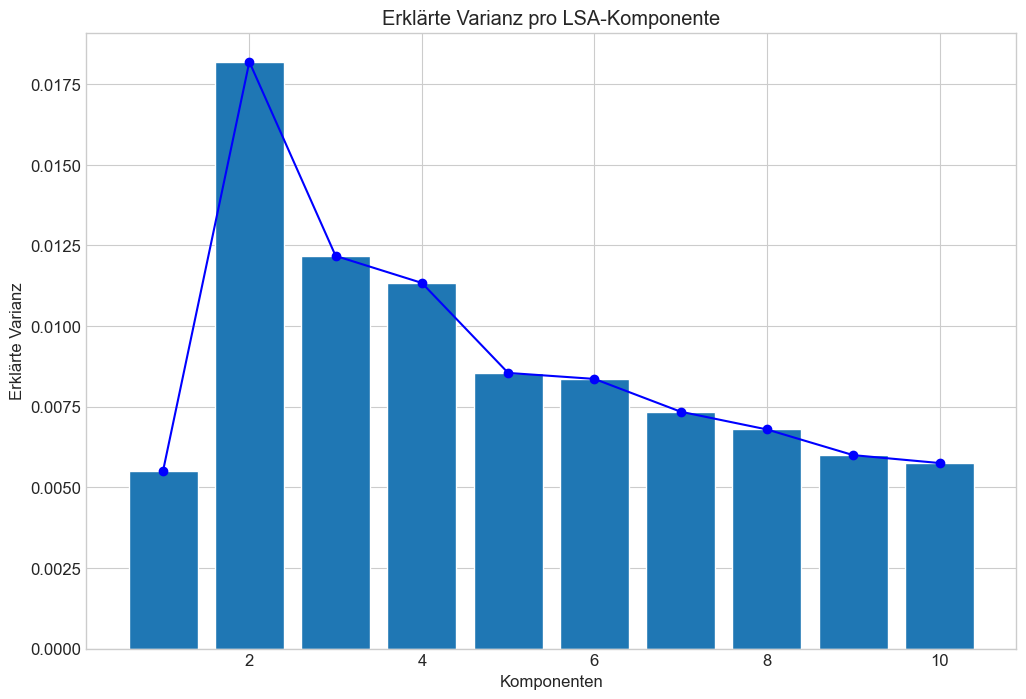

In [6]:
# Visualisierung der erklärten Varianz

plt.plot(range(1, n_components_lsa + 1), lsa_model.explained_variance_ratio_, 'b-', marker='o')
plt.bar(range(1, n_components_lsa + 1), lsa_model.explained_variance_ratio_)
plt.xlabel('Komponenten')
plt.ylabel('Erklärte Varianz')
plt.title('Erklärte Varianz pro LSA-Komponente')
plt.show()


In [7]:
# Top Begriffe je LSA-Komponente identifizieren
feature_names = tfidf_vectorizer.get_feature_names_out()
lsa_components_df = pd.DataFrame()

# Speichern der wichtigsten Begriffe für jede Komponente
n_top_words = 20
lsa_top_words = {}

for i, component in enumerate(lsa_model.components_): # Iterate über jedes LSA-Thema
    # Indizes der Wörter mit den höchsten Werten
    top_indices = component.argsort()[:-n_top_words-1:-1] 
    top_words = [feature_names[idx] for idx in top_indices]
    top_weights = [component[idx] for idx in top_indices]
    
    # Als Dataframe speichern
    component_df = pd.DataFrame({
        'Word': top_words,
        'Weight': top_weights
    })
    lsa_components_df = pd.concat([lsa_components_df, component_df], axis=1)
    
    # Für JSON speichern
    lsa_top_words[f"topic_{i+1}"] = [
        {"word": word, "weight": float(weight)} 
        for word, weight in zip(top_words, top_weights)
    ]
    
    print(f"LSA Thema {i+1}: {', '.join(top_words[:10])}")


# LSA-Themen als JSON speichern
with open('../results/lsa_topics.json', 'w') as f:
    json.dump(lsa_top_words, f, indent=4)


LSA Thema 1: credit, account, payment, loan, report, debt, bank, would, card, call
LSA Thema 2: credit, report, credit report, debt, reporting, collection, account, agency, experian, equifax
LSA Thema 3: debt, call, collection, phone, number, company, calling, loan, collection agency, agency
LSA Thema 4: loan, mortgage, report, credit report, payment, credit, modification, home, reporting, owen
LSA Thema 5: account, debt, bank, collection, payment, agency, fee, check, collection agency, bank america
LSA Thema 6: payment, debt, late, paid, card, collection, balance, fee, bill, interest
LSA Thema 7: debt, card, credit card, fargo, well fargo, bank, well, loan, america, bank america
LSA Thema 8: fargo, well fargo, well, payment, late, fargo bank, call, bill, late fee, account
LSA Thema 9: loan, account, student, student loan, interest, collection, rate, paid, private, school
LSA Thema 10: bank, america, bank america, credit report, report, debt, check, credit, payment, fee


In [8]:
##########################################################
# 2. Latent Drichilet Allocation (LDA) mit Bag Of Words
##########################################################

# Funktion zur Berechnung von Kohärenzwerten (hier als Log-Likelihood) und Perplexity für verschiedene Topic-Anzahlen
def compute_coherence_values(count_matrix, count_vect, start=2, limit=20, step=2):
    coherence_values = []    # Liste zur Speicherung der Kohärenzwerte (Log-Likelihoods) für jedes Modell
    model_list = []          # Liste zur Speicherung der trainierten LDA-Modelle
    perplexity_values = []   # Liste zur Speicherung der Perplexity-Werte (ein Maß für Modellqualität)

    # Schleife über die gewünschte Anzahl an Themen (z. B. 2, 4, 6, ..., 20)
    for num_topics in range(start, limit+1, step):
        print(f"LDA Modell mit {num_topics} Themen trainieren...")

        # https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.LatentDirichletAllocation.html
        # Initialisierung eines LDA-Modells mit aktueller Themenanzahl
        lda = LatentDirichletAllocation(
            n_components=num_topics,       # Anzahl der zu entdeckenden Themen (Topics)
            max_iter=5,                    # Anzahl der Trainingsdurchläufe (Iterationen)
            learning_method='online',      # Lernmethode: 'online' für inkrementelles Training (schneller bei großen Datensätzen)
            random_state=42,               # Zufallsstart fixieren für Reproduzierbarkeit
            batch_size=128,                # Anzahl der Dokumente pro Mini-Batch beim Training
            n_jobs=-1,                     # Alle verfügbaren CPU-Kerne nutzen
            verbose=0,                     # Keine Ausgaben während des Trainings (0 = keine Ausgabe, 1 = Fortschritt anzeigen)
        )

        # LDA-Modell auf der Dokument-Term-Matrix trainieren
        lda.fit(count_matrix)

        # Perplexity berechnen (niedriger ist besser; misst, wie gut das Modell neue Daten erklärt)
        perplexity_values.append(lda.perplexity(count_matrix))

        # Das trainierte Modell zur späteren Analyse speichern
        model_list.append(lda)

        # Log-Likelihood berechnen (höher ist besser; Maß für die Modellgüte während des Trainings)
        coherence_values.append(lda.score(count_matrix))

    # Rückgabe: Liste der Modelle, Liste der Kohärenzwerte, Liste der Perplexity-Werte
    return model_list, coherence_values, perplexity_values


In [9]:
# Die Variablen start, limit und step definieren die Anzahl der Themen, die getestet werden sollen und sind für die Funktion compute_coherence_values() unter dieser Zelle.
# Das ist extra hier, damit nach dem Training der Modelle, die Darstellung ohne erneutiges Training der Modelle erfolgen kann.
# Beispiel: range(2, 21, 2) → [2, 4, 6, ..., 20]
start, limit, step = 2, 10, 2

In [10]:
# Nach der ersten Darstellung der LDA-Modelle mit 20 Themen, wurde die Anzahl der Themen auf 10 reduziert, weil nach 10 Themen nicht die Perplexity nicht mehr so stark fällt. 
# Dadurch war das Training nach 6 Minuten (auf dem Macbook Pro) und 11 Minuten (am anderen Computer) fertig.
# Diese Funktion nimmt einige Zeit in Anspruch, deshalb wurde auch n_jobs auf alle CPUs gestellt. 
# Die ersten Test: Mit 5 Durchläufen ca. 20 Minuten.  Bei 10 waren es mehr als 1h. Durch max_iter auf 5, bei 10 Durchgängen ca. 28 Minuten.
# Definiert den Bereich für die Anzahl der LDA-Themen:
# start = kleinste Themenanzahl, limit = größte Themenanzahl, step = Schrittweite zwischen den Tests -> für range()

model_list, coherence_values, perplexity_values = compute_coherence_values(
    count_matrix, count_vectorizer, start=start, limit=limit, step=step
)

print("Training der LDA-Modelle abgeschlossen.")

LDA Modell mit 2 Themen trainieren...
LDA Modell mit 4 Themen trainieren...
LDA Modell mit 6 Themen trainieren...
LDA Modell mit 8 Themen trainieren...
LDA Modell mit 10 Themen trainieren...
Training der LDA-Modelle abgeschlossen.


In [11]:
# Finde den Index des besten Wertes (höchste Kohärenz / Log Likelihood) in der Liste
optimal_model_idx = coherence_values.index(max(coherence_values))

# Rechne aus, wie viele Themen das Modell mit dem besten Wert hatte
optimal_num_topics = start + optimal_model_idx * step

# (Startwert + Index * Schrittweite)
print(f"Optimale Anzahl Themen basierend auf Log Likelihood: {optimal_num_topics}")

Optimale Anzahl Themen basierend auf Log Likelihood: 10


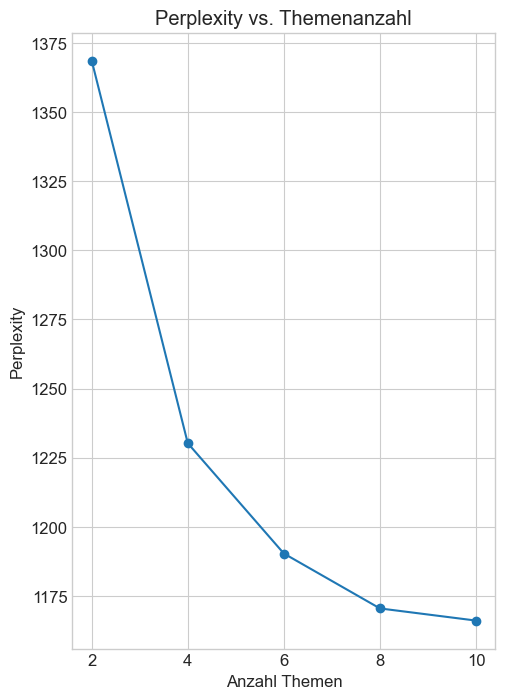

In [12]:
# Kohärenzwerte visualisieren
x = range(start, limit+1, step)


# Plot für Perplexity/Verwirrung/Verworrenheit (niedriger ist besser)
plt.subplot(1, 2, 1)
plt.plot(x, perplexity_values, marker='o')
plt.xlabel("Anzahl Themen")
plt.ylabel("Perplexity")
plt.title("Perplexity vs. Themenanzahl")

plt.show()

# Bestes LDA-Modell verwenden
best_lda_model = model_list[optimal_model_idx]

# LDA-Themen Visualisierung
feature_names = count_vectorizer.get_feature_names_out()
lda_top_words = {}

In [13]:
print("\nLDA Themen und deren charakteristische Begriffe:")
# Iteriere über jedes LDA-Thema und finde die Top-Wörter
for i, topic in enumerate(best_lda_model.components_):  # Iteration über jedes LDA-Thema
    # Indizes der Wörter mit den höchsten Werten | Der Slice-Operator [:-n_top_words-1:-1] gibt die n_top_words größten Werte zurück
    # und sortiert sie in absteigender Reihenfolge
    top_indices = topic.argsort()[:-n_top_words-1:-1]
    top_words = [feature_names[j] for j in top_indices] # Liste der Wörter mit den höchsten Werten
    top_weights = [topic[j] for j in top_indices]       # Liste der Gewichtungen der Wörter
    
    lda_top_words[f"topic_{i+1}"] = [                   # 
        {"word": word, "weight": float(weight)}         # Speichern der Wörter und deren Gewichtung
        for word, weight in zip(top_words, top_weights) # Liste der Wörter und deren Gewichtung
    ]
    
    print(f"LDA Thema {i+1}: {', '.join(top_words[:10])}") # Ausgabe der ersten 10 Begriffe, kann geändert werden 


LDA Themen und deren charakteristische Begriffe:
LDA Thema 1: credit, report, account, credit report, reporting, information, bureau, reported, removed, dispute
LDA Thema 2: payment, late, paid, fee, balance, account, due, month, amount, statement
LDA Thema 3: well, fargo, well fargo, home, closing, appraisal, sale, property, offer, contract
LDA Thema 4: would, get, told, time, said, money, could, back, help, year
LDA Thema 5: debt, letter, collection, sent, received, agency, company, collection agency, account, owe
LDA Thema 6: call, phone, called, number, told, company, asked, time, received, would
LDA Thema 7: loan, payment, interest, rate, month, car, one, pay, capital, interest rate
LDA Thema 8: information, complaint, consumer, request, provide, law, state, provided, document, act
LDA Thema 9: account, card, bank, credit, credit card, check, charge, customer, fee, fund
LDA Thema 10: mortgage, loan, home, modification, bank, foreclosure, property, tax, escrow, letter


In [14]:
# LDA-Themen als JSON speichern
with open('../results/lda_topics.json', 'w') as f:
    json.dump(lda_top_words, f, indent=4)

# LDA-Modell speichern
joblib.dump(best_lda_model, '../models/best_lda_model.joblib')

['../models/best_lda_model.joblib']

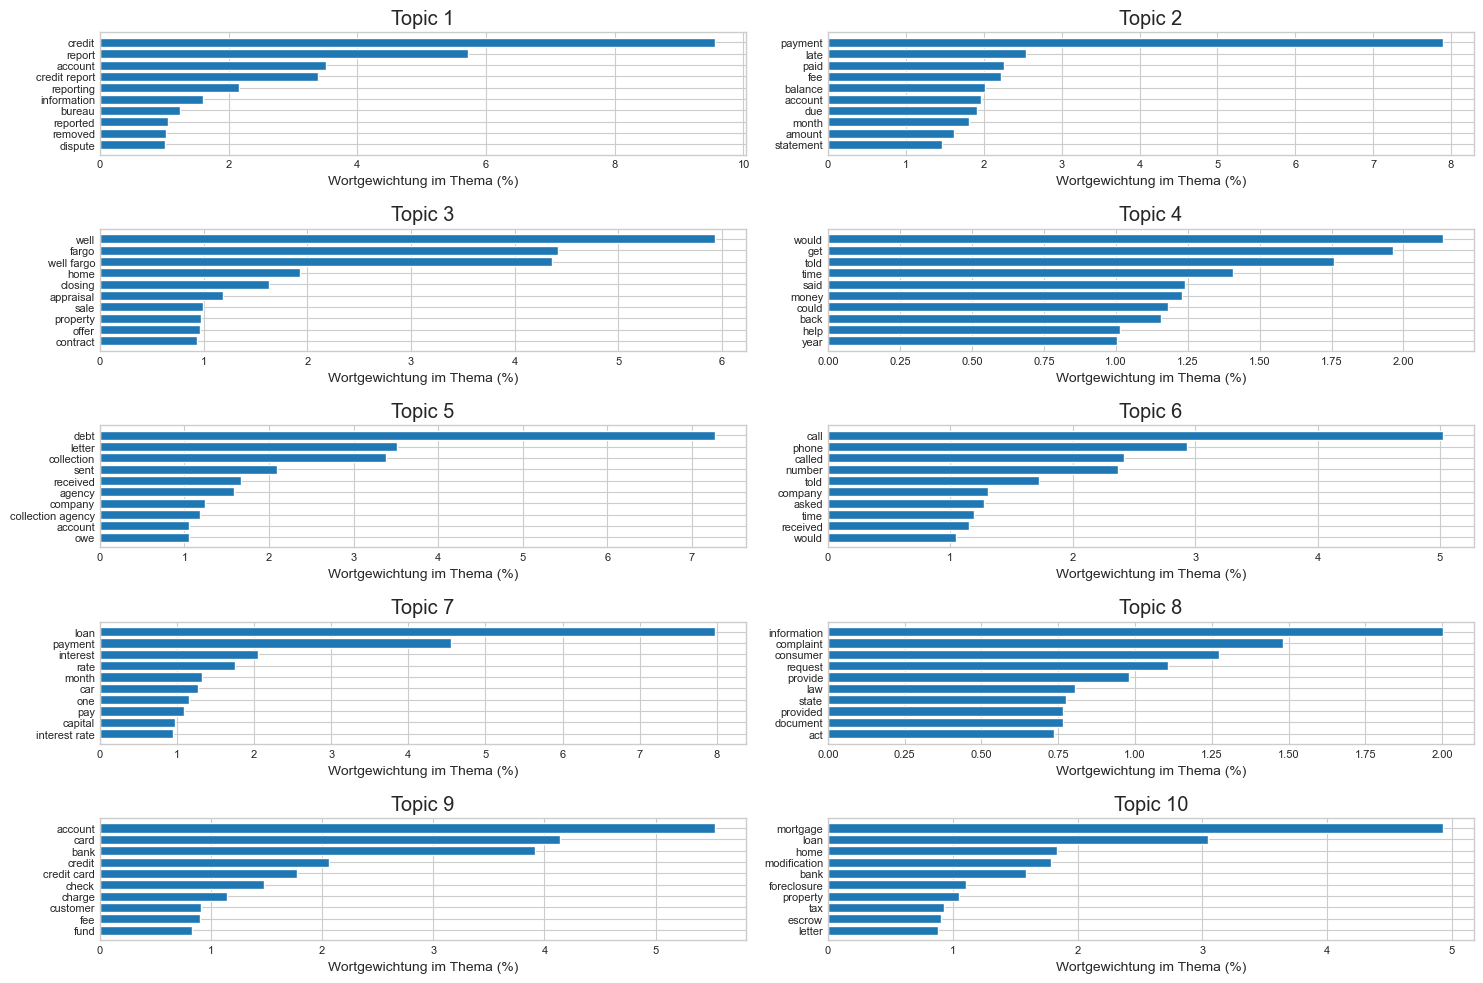

In [15]:
plt.figure(figsize=(15, 10))
for topic_idx, topic in enumerate(best_lda_model.components_):                  # Iteriere über alle Themen im besten LDA-Modell
    top_features_ind = topic.argsort()[:-10 - 1:-1]                             # Indexe der Top 10 Wörter im Thema nach Gewichtung (absteigend)
    top_features = [feature_names[i] for i in top_features_ind]                 # Hole die tatsächlichen Wörter (Feature-Namen) zu den Indexen
    
    # Gewichtungen in Prozent umrechnen (sieht besser aus, als riesige Zahlen)
    # topic[top_features_ind] gibt die Gewichtungen der Top-Wörter zurück, und topic.sum() gibt die Summe aller Gewichtungen im Thema zurück 
    weights = topic[top_features_ind] / topic.sum() * 100

    # Barplot erstellen
    # plt.subplot(int(np.ceil(optimal_num_topics / 2)), 2, topic_idx + 1) # Anzahl der Subplots in der Figur (2 Spalten, so viele Zeilen wie nötig)
    ax = plt.subplot(int(np.ceil(optimal_num_topics / 2)), 2, topic_idx + 1)
    
    # plt.barh(top_features, weights) # Erstelle ein horizontales Balkendiagramm mit den Top-Wörtern und deren Gewichtungen
    ax.barh(top_features, weights)
    ax.set_title(f'Topic {topic_idx + 1}')
    ax.invert_yaxis()
    ax.tick_params(axis='both', which='major', labelsize=8)
    ax.set_xlabel('Wortgewichtung im Thema (%)', fontsize=10)

plt.tight_layout()




In [16]:

# Funktion zur Erstellung von Wortwolken für die Themen
def create_wordcloud_for_topics(model, feature_names, n_topics, topic_type="LDA"):
    # Farben für jedes Thema definieren
    # Hier wird eine Farbkarte mit 10 Farben erstellt, die für die Themen verwendet wird
    colors = cm.tab10(np.linspace(0, 1, n_topics))
    
    # Wortwolken für jedes Thema erstellen 
    fig, axes = plt.subplots(int(np.ceil(n_topics/2)), 2, figsize=(16, int(np.ceil(n_topics/2)*8))) # 
    axes = axes.flatten()
    
    # Iteriere über jedes Thema und erstelle eine Wortwolke
    for i, topic in enumerate(model.components_):
        top_indices = topic.argsort()[:-50-1:-1] # 
        top_words = {feature_names[j]: float(topic[j]) for j in top_indices}
        
        # Wortwolke mit gewichteten Wörtern erstellen
        wordcloud = WordCloud(
            background_color='white',
            width=800, 
            height=400,
            max_words=35, # maximale Anzahl der Wörter in der Wolke, darf gerne geändert werden. 

            
            colormap=f'tab10',
            color_func=lambda *args, **kwargs: tuple(int(v*255) for v in colors[i][:3]), #
            prefer_horizontal=1.0
        ).generate_from_frequencies(top_words)
        
        axes[i].imshow(wordcloud, interpolation='bilinear')
        axes[i].set_title(f"{topic_type} Thema {i+1}", fontsize=16)
        axes[i].axis('off')
    
    # Leere Subplots ausblenden
    for i in range(n_topics, len(axes)):
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.savefig(f'../results/{topic_type.lower()}_wordclouds.png', dpi=300, bbox_inches='tight')




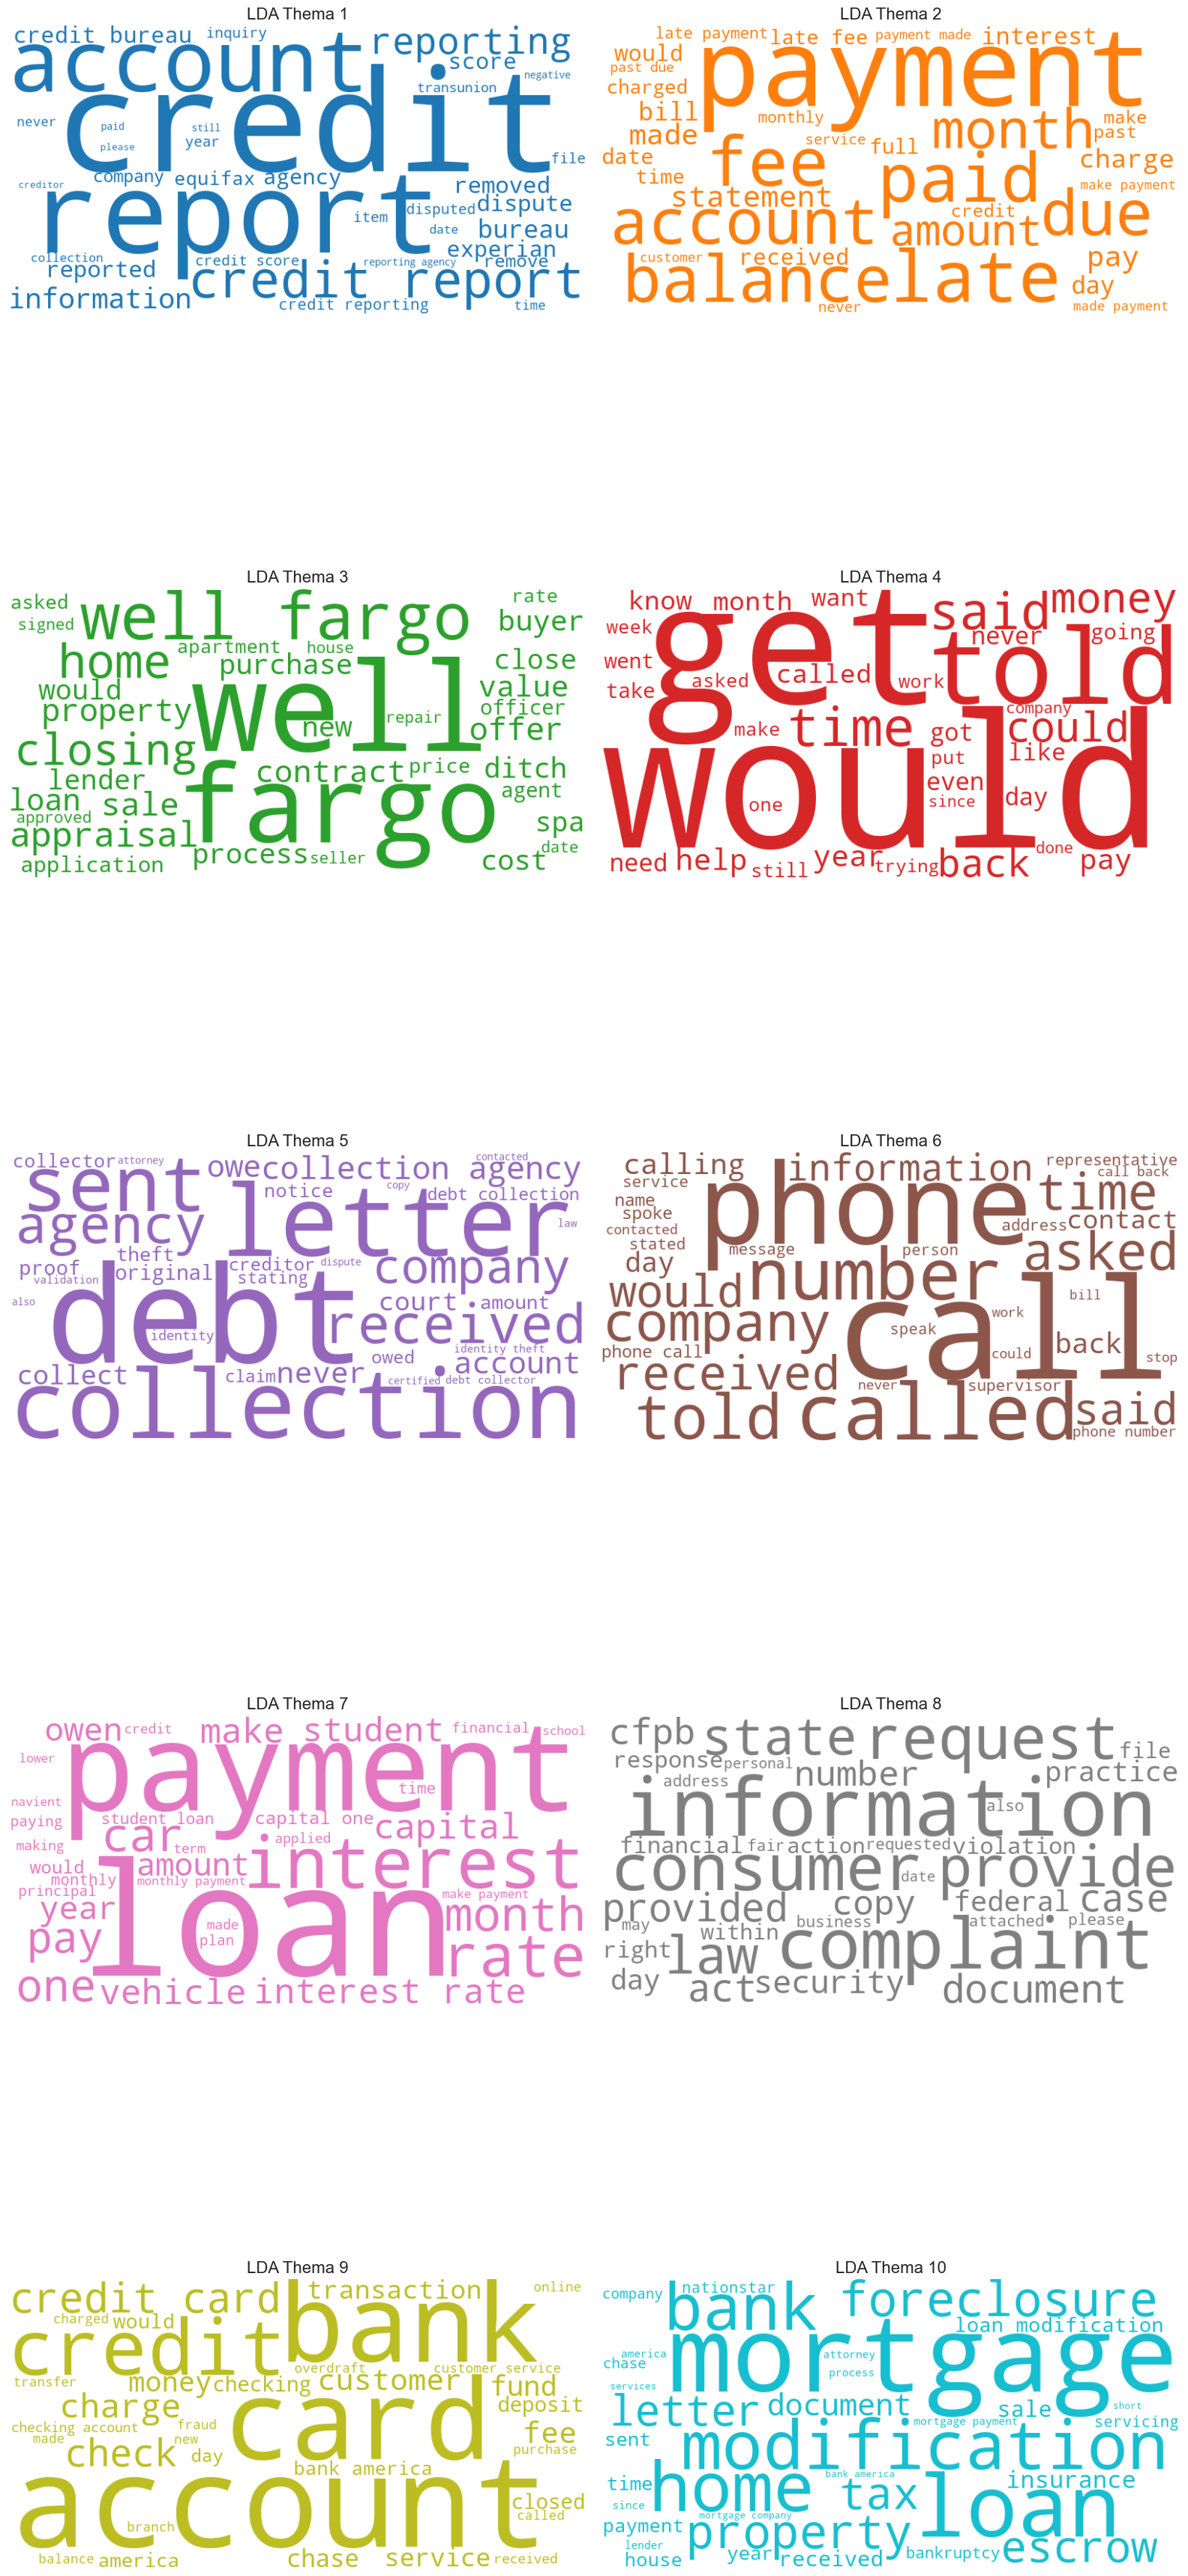

In [17]:
# Word Clouds für LDA-Themen
create_wordcloud_for_topics(
    best_lda_model, 
    count_vectorizer.get_feature_names_out(), 
    optimal_num_topics, 
    "LDA"
)

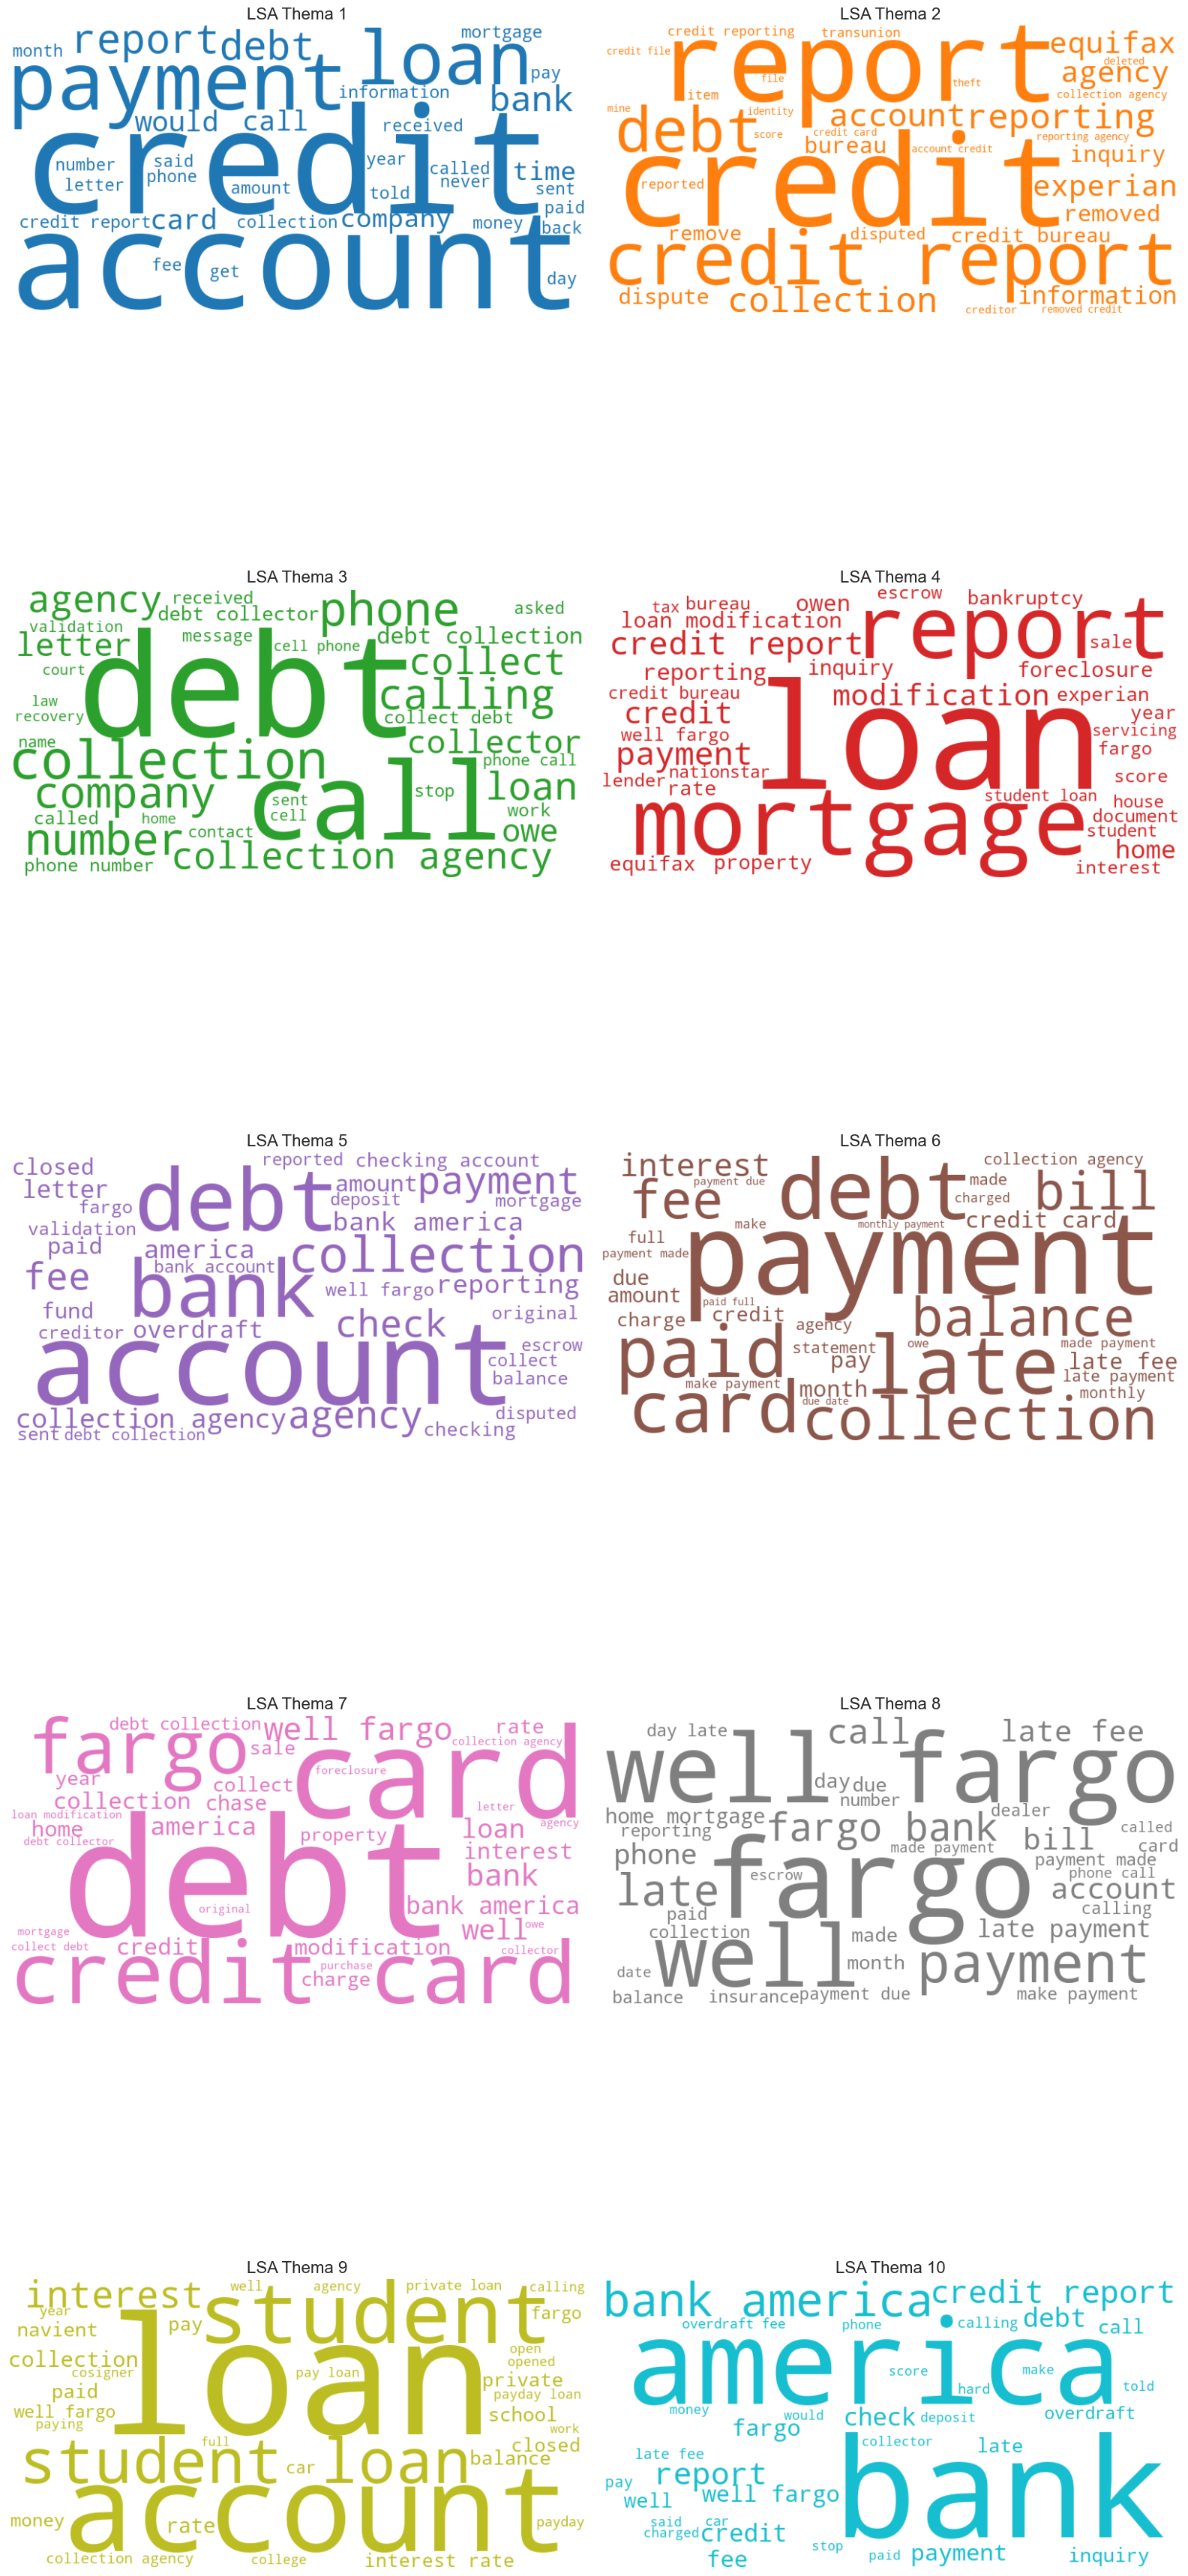

In [18]:
# Word Clouds für LSA-Themen
create_wordcloud_for_topics(
    lsa_model, 
    tfidf_vectorizer.get_feature_names_out(), 
    n_components_lsa, 
    "LSA"
)